In [2]:
# https://zhijingeu.medium.com/building-a-natural-language-enabled-pandas-dataframe-agent-with-langchain-openai-f23ac12180df
import pandas as pd

from langchain.llms import Clarifai
from langchain.agents import create_pandas_dataframe_agent

In [3]:
observations = pd.read_csv("csv/observations.csv")
observations.shape

(299697, 8)

# Preprocessing

In [4]:
observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299697 entries, 0 to 299696
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   DATE         299697 non-null  object
 1   PATIENT      299697 non-null  object
 2   ENCOUNTER    269334 non-null  object
 3   CODE         299697 non-null  object
 4   DESCRIPTION  299697 non-null  object
 5   VALUE        299697 non-null  object
 6   UNITS        286962 non-null  object
 7   TYPE         299697 non-null  object
dtypes: object(8)
memory usage: 18.3+ MB


In [29]:
observations = observations[observations.TYPE=="numeric"]
observations = observations[observations.UNITS!="{score}"]
observations = observations[~observations.DESCRIPTION.isin(["DALY", "QALY"])]
observations["VALUE"] = observations["VALUE"].astype(float)
observations["DATE"] = pd.to_datetime(observations.DATE)
observations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119302 entries, 0 to 299665
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   DATE         119302 non-null  datetime64[ns, UTC]
 1   PATIENT      119302 non-null  object             
 2   ENCOUNTER    119302 non-null  object             
 3   CODE         119302 non-null  object             
 4   DESCRIPTION  119302 non-null  object             
 5   VALUE        119302 non-null  float64            
 6   UNITS        119302 non-null  object             
 7   TYPE         119302 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(6)
memory usage: 8.2+ MB


<Axes: >

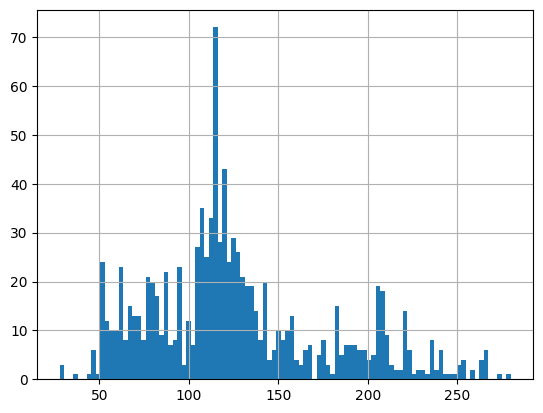

In [26]:
tmp = observations.PATIENT.value_counts()
tmp[tmp<300].hist(bins=100)

In [30]:
observations = observations[observations.PATIENT.isin(tmp[tmp<300].index)]
observations.shape

(119302, 8)

In [35]:
observations[observations.PATIENT==observations.PATIENT.unique()[0]].DATE.dt.strftime('%Y-%m-%d').value_counts()

2018-01-29    22
2012-01-23    18
2015-01-26    11
2017-01-09     7
Name: DATE, dtype: int64

In [36]:
observations["DATE"] = observations.DATE.dt.strftime('%Y-%m-%d')

In [39]:
tmp = [observations[observations.PATIENT==pat].DATE.value_counts().values for pat in observations.PATIENT.unique()]

In [41]:
len(tmp), observations.PATIENT.nunique()

(1009, 1009)

In [42]:
pd.Series([len(pat) for pat in tmp]).describe()

count    1009.000000
mean       10.601586
std         4.359336
min         2.000000
25%         8.000000
50%        11.000000
75%        13.000000
max        61.000000
dtype: float64

In [43]:
pd.Series(observations.PATIENT.unique())[[len(pat)<20 for pat in tmp]]

0       034e9e3b-2def-4559-bb2a-7850888ae060
1       8d4c4326-e9de-4f45-9a4c-f8c36bff89ae
2       10339b10-3cd1-4ac3-ac13-ec26728cb592
3       1d604da9-9a81-4ba9-80c2-de3375d59b40
4       f5dcd418-09fe-4a2f-baa0-3da800bd8c3a
                        ...                 
1004    09867b02-24b8-4896-b38b-86782dd64ef1
1005    1fc8dafd-90e5-44d6-9179-81156c0ea083
1006    6d048a56-edb8-4f29-891d-7a84d75a8e78
1007    fca3178e-fb68-41c3-8598-702d3ca68b96
1008    fc817953-cc8b-45db-9c85-7c0ced8fa90d
Length: 990, dtype: object

In [44]:
observations = observations[observations.PATIENT.isin(pd.Series(observations.PATIENT.unique())[[len(pat)<20 for pat in tmp]])]
observations.shape

(115917, 8)

In [47]:
observations = observations[["DATE", "PATIENT", "DESCRIPTION", "VALUE", "UNITS"]]
observations.to_csv("csv/observations_processed.csv", index=False)

In [52]:
responses = pd.read_csv("csv/observations_responses.csv", sep="#")
responses.head()

,PATIENT,DATE,RESPONSE
0,034e9e3b-2def-4559-bb2a-7850888ae060,2012-01-23,"Based on the provided observations, here is an..."
1,034e9e3b-2def-4559-bb2a-7850888ae060,2015-01-26,"Based on the provided observations, here are t..."
2,034e9e3b-2def-4559-bb2a-7850888ae060,2017-01-09,"Based on the provided observations, here are t..."
3,034e9e3b-2def-4559-bb2a-7850888ae060,2018-01-29,"Based on the provided observations, here are s..."
4,8d4c4326-e9de-4f45-9a4c-f8c36bff89ae,2011-11-17,"Based on the provided observation, here is the..."


In [56]:
print(responses.RESPONSE[3].replace("  ", "\n"))

Based on the provided observations, here are some findings:
**Abnormal Values:** 1. Diastolic Blood Pressure: 85 mm[Hg] (Normal range: <80 mm[Hg]) 2. Total Cholesterol: 165.5 mg/dL (Borderline high, normal range: <200 mg/dL) 3. Triglycerides: 113.3 mg/dL (Borderline high, normal range: <150 mg/dL) 4. Low Density Lipoprotein Cholesterol: 80.7 mg/dL (Borderline high, normal range: <100 mg/dL) 5. High Density Lipoprotein Cholesterol: 62.2 mg/dL (Normal range: >40 mg/dL for males, >50 mg/dL for females)
**Possible Diagnoses:** 1. Borderline High Blood Pressure (Isolated diastolic hypertension). 2. Borderline High Cholesterol levels.
**Further Workup Recommendations:** 1. **Blood Pressure Management:** Monitor blood pressure regularly. Lifestyle modifications like a heart-healthy diet, regular exercise, and stress management techniques can help. If blood pressure remains elevated, medication may be considered.
2. **Lipid Profile:** Consider a complete lipid profile including LDL particle si

In [60]:
int(responses.RESPONSE[3].split("Recommendations:** ")[-1].count("**")/2)

7

# LLM

In [6]:
CLARIFAI_PAT=""

In [7]:
# https://python.langchain.com/docs/integrations/llms/clarifai
clarifai_llm = Clarifai(
    pat=CLARIFAI_PAT, user_id='openai', app_id='chat-completion', model_id='GPT-3_5-turbo'
)

In [8]:
agent = create_pandas_dataframe_agent(
    clarifai_llm,
    observations,
    verbose=True
)

In [15]:
agent.run("How many patients does the dataset include?")



> Entering new AgentExecutor chain...


Thought: I need to count the number of unique patient identifiers in the dataframe.
Action: Use the `nunique()` function on the 'PATIENT' column of the dataframe.
Action Input: `df['PATIENT'].nunique()`
Observation: Use the `nunique()` function on the 'PATIENT' column of the dataframe. is not a valid tool, try one of [python_repl_ast].
Thought:I need to use the Python shell to execute the command.
Action: python_repl_ast
Action Input: `df['PATIENT'].nunique()`
Observation: 1171
Thought:There are 1171 unique patients in the dataset.
Final Answer: 1171

> Finished chain.


'1171'